In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import load_dataset
import os
import wandb
import matplotlib.pyplot as plt

In [2]:
# Initialize Weights & Biases (wandb)
wandb.init(project="NanoGPT-Full-Training", name="GPT2-Training-Run")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: rajanthakullavlogs (rajanthakullavlogs-rajan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


Using device: cuda


In [4]:

# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set padding token
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
model.gradient_checkpointing_enable()  # Enable gradient checkpointing to reduce memory


In [5]:
# Load Dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
dataset = dataset.filter(lambda example: example["text"].strip() != "")



Filter:   0%|          | 0/4358 [00:00<?, ? examples/s]

Filter:   0%|          | 0/36718 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [6]:

def tokenize_function(examples):
    # Remove empty strings before tokenization
    non_empty_texts = [text for text in examples["text"] if text.strip() != ""]
    return tokenizer(non_empty_texts, truncation=True, padding="max_length", max_length=512)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Reduce dataset size for memory efficiency
tokenized_datasets["train"] = tokenized_datasets["train"].select(range(5000))  # Keep only 5000 samples
tokenized_datasets["validation"] = tokenized_datasets["validation"].select(range(1000))

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False  # No masked language modeling for GPT
)


Map:   0%|          | 0/2891 [00:00<?, ? examples/s]

Map:   0%|          | 0/23767 [00:00<?, ? examples/s]

Map:   0%|          | 0/2461 [00:00<?, ? examples/s]

In [7]:

# Training Arguments with optimizations
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=500,
    logging_steps=100,
    save_steps=1000,
    learning_rate=5e-5,
    per_device_train_batch_size=2,  # Reduced batch size to avoid RAM overflow
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    report_to=["wandb"],
    run_name="GPT2-Training-Run",
    push_to_hub=False,
    fp16=True  # Enable mixed precision training for memory optimization
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)



C:\Users\Rajan\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Rajan\AppData\Local\Temp\ipykernel_1500\633985400.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [8]:
# Train Model
trainer.train()

# Save Model
model.save_pretrained("./trained_gpt2")
tokenizer.save_pretrained("./trained_gpt2")



`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
C:\Users\Rajan\anaconda3\Lib\site-packages\transformers\integrations\sdpa_attention.py:53: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
500,3.423900,3.462372
1000,3.289000,3.427315
1500,3.202200,3.379534
2000,3.208400,3.376565
2500,3.080900,3.363090
3000,2.852000,3.391434
3500,2.757800,3.392890
4000,2.787900,3.395272
4500,2.697800,3.395161
5000,2.806400,3.387486


('./trained_gpt2\\tokenizer_config.json',
 './trained_gpt2\\special_tokens_map.json',
 './trained_gpt2\\vocab.json',
 './trained_gpt2\\merges.txt',
 './trained_gpt2\\added_tokens.json')

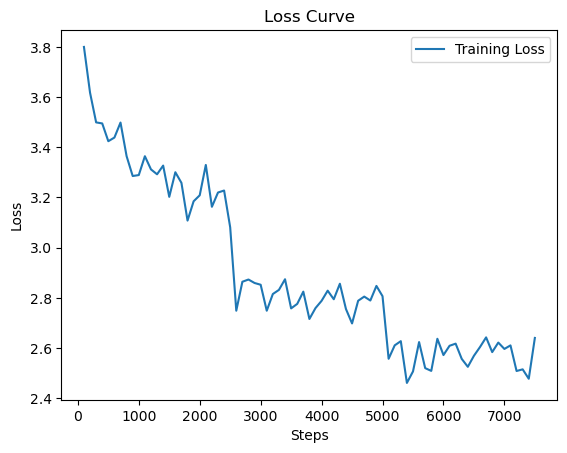

In [9]:
# Plot Loss Graphs
def plot_loss():
    history = trainer.state.log_history
    steps = [x["step"] for x in history if "loss" in x]
    losses = [x["loss"] for x in history if "loss" in x]
    plt.plot(steps, losses, label="Training Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.show()

plot_loss()



In [10]:
# Text Generation Function
def generate_text(prompt, max_length=100):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        outputs = model.generate(**inputs, max_length=max_length, temperature=0.7, top_k=50)
        return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [14]:
# User Input and Text Generation
#prompt = input("Enter your prompt: ")
prompt = "write an essay on cow" 
output_text = generate_text(prompt)
print("Generated Output:\n", output_text)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Output:
 write an essay on cow protection in the journal Animal Welfare International . 
 
 
                                                                                 


In [12]:
# Questions for Evaluation
questions = [
    "How does GPT-2 generate text?",
    "What is the significance of top-k sampling in text generation?",
    "How does loss impact language model performance?",
    "Why do we use Wikitext-2 dataset for fine-tuning?"
]
print("\nQuestions to Consider:")
for i, q in enumerate(questions, 1):
    print(f"{i}. {q}")



Questions to Consider:
1. How does GPT-2 generate text?
2. What is the significance of top-k sampling in text generation?
3. How does loss impact language model performance?
4. Why do we use Wikitext-2 dataset for fine-tuning?


In [13]:
print(f"Number of validation samples: {len(tokenized_datasets['validation'])}")
print(tokenized_datasets['validation'][0])


Number of validation samples: 1000
{'text': ' = Homarus gammarus = \n', 'input_ids': [796, 8074, 20272, 9106, 3876, 385, 796, 220, 198, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 502